# Error Visualization
This notebook categorizes the errors encountered when running the AutoML benchmark creates visualizations that show when, where, and why errors happen.


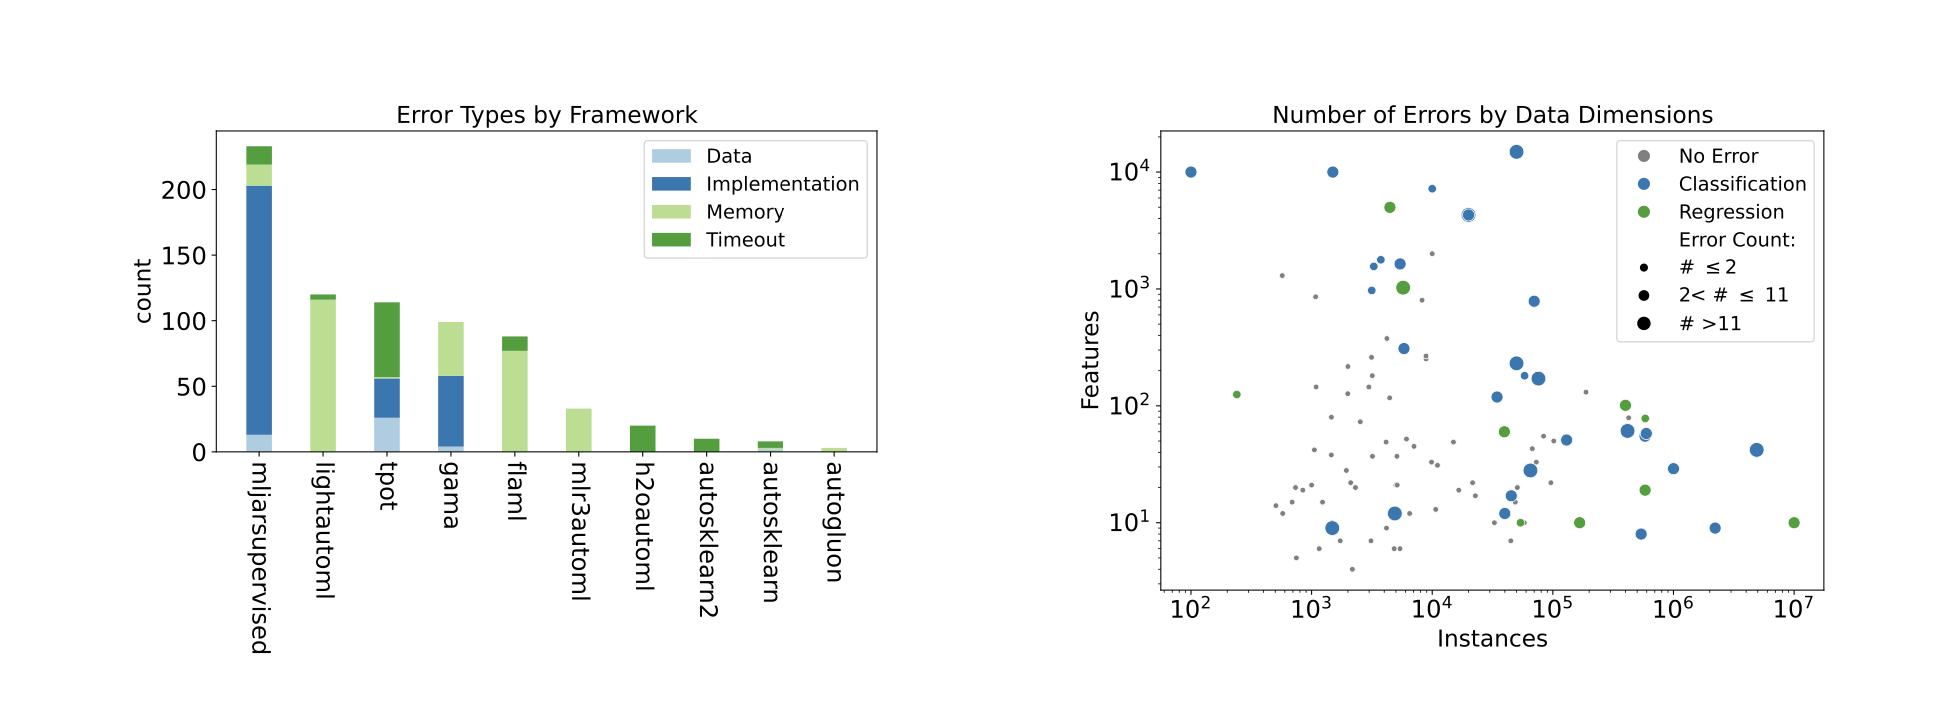

### Loading Data

In [1]:
import itertools
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns

from data_processing import get_print_friendly_name

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "errors"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)
results = results[results["framework"] != "NaiveAutoML"]

## Categorizing Errors

In [40]:
with_errors = results[~results["info"].isna()][["framework", "task", "fold", "constraint", "info", "metric"]]

In [41]:
TIMEOUT_PATTERN = re.compile("Interrupting thread MainThread \[ident=\d+\] after \d+s timeout.")
def is_timeout(message: str) -> bool:
    if re.search(TIMEOUT_PATTERN, message):
        return True
    return False

In [42]:
def is_memory(message: str) -> bool:
    if "Cannot allocate memory" in message:
        return True
    if "exit status 134" in message:
        return True
    if "exit status 137" in message:
        return True
    if "exit status 139" in message:
        return True
    if "exit status 143" in message:
        return True
    if "std::bad_alloc" in message:
        return True
    if "Dummy prediction failed with run state StatusType.MEMOUT" in message:
        return True  # autosklearn
    if "This could be caused by a segmentation fault while calling the function or by an excessive memory usage" in message:
        return True  # lightautoml
    if "OutOfMemoryError: GC overhead limit exceeded" in message:
        return True  # H2O
    return False

In [43]:
def is_data(message: str) -> bool:
    if "NoResultError: y_true and y_pred contain different number of classes" in message:
        return True
    if "The least populated class in y has only 1 member, which is too few." in message:
        return True  # GAMA
    return False

In [44]:
def is_implementation(message: str) -> bool:
    if "Unsupported metric `auc` for regression problems" in message:
        return True  # FLAML produces NaN predictions
    if "A pipeline has not yet been optimized. Please call fit() first." in message:
        return True  # TPOT
    if message == "NoResultError: probability estimates are not available for loss='hinge'":
        return True  # TPOT
    if  "object has no attribute 'predict_proba'" in message:
        return True  # TPOT
    if "'NoneType' object is not iterable" in message:
        return True  # GAMA
    if message == "NoResultError: ":
        return True  # GAMA
    if "Ran out of input" in message:
        return True  # GAMA
    if "Python int too large to convert to C ssize_t" in message:
        return True  # GAMA
    if "invalid load key, " in message:
        return True  # GAMA
    if "Pipeline finished with 0 models for some reason." in message:
        return True  # Light AutoML
    if "No models produced. \nPlease check your data or submit" in message:
        return True  # MLJar
    if "Object of type float32 is not JSON serializable" in message:
        return True  # MLJar
    if "The feature names should match those that were passed during fit" in message:
        return True  # MLJar
    if re.search("At position \d+ should be feature with name", message):
        return True  # MLJar
    if "Ensemble_prediction_0_for_" in message:
        return True  # MLJar
    if "NeuralNetFastAI_BAG_L1'" in message:
        return True  # AutoGluon
    if "No learner was chosen in the initial phase." in message:
        return True  # NaiveAutoML
    return False

In [45]:
def needs_investigation(message: str) -> bool:
    return False

In [46]:
def confirmed_fixed(message: str) -> bool:
    if "'NoneType' object has no attribute 'name'" in message:
        return True  # bug with infer_limit set in 0.8.0, fixed in 0.8.3.
    return False

In [47]:
def needs_rerun(message: str) -> bool:
    if "NoResultError: 'e'" in message:
        return True  # Autosklearn artifact save bug
    if "Auto-sklearn does not yet support sparse pandas Series" in message:
        return True  # Autosklearn
    if re.search("Exception: File: /input/org/openml/www/datasets/\d+/dataset_\d+.pq", message):
        return True
    return False

In [48]:
checks = dict(
    timeout=is_timeout,
    memory=is_memory,
    data=is_data,
    implementation=is_implementation,
    fixed=confirmed_fixed,
    rerun=needs_rerun,
    investigate=needs_investigation,
)

def classify_error(message: str):
    for type_, check in checks.items():
        if check(message):
            return type_
    return "unknown"

In [49]:
with_errors["error_type"] = with_errors["info"].apply(classify_error)

#### Expand the above check functions until no unknown errors are left below

In [50]:
if n_errors:= len(with_errors[with_errors["error_type"] == "unknown"]["info"].unique()):
    print(n_errors)
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0])
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0]["info"])

#### Run below to find runs to redo

In [51]:
results.loc[with_errors[(with_errors["error_type"] == "rerun" )].index]

,id,task,framework,constraint,fold,type,result,metric,mode,version,...,mae,r2,rmse,source,infer_batch_size_df_1,infer_batch_size_file_1,infer_batch_size_file_10,infer_batch_size_file_100,infer_batch_size_file_1000,infer_batch_size_file_10000


## Visualizing Errors by Framework

In [52]:
error_counts = with_errors.groupby(["framework", "error_type"], as_index=False).count()    

In [53]:
frameworks = list(with_errors.groupby("framework").count().task.sort_values(ascending=False).index)
error_types = error_counts["error_type"].unique()

In [54]:
all_combinations = pd.DataFrame(itertools.product(error_types, frameworks), columns=["error_type", "framework"])
error_counts = pd.concat([error_counts, all_combinations]).drop_duplicates(subset=["error_type", "framework"], keep='first')
error_counts = error_counts.fillna(0)

In [55]:
color_by_error_type = {
    "data": "#a6cee3",  #light blue
    "implementation": "#2078b4", # dark blue
    "memory": "#A7CE85", #light green
    "timeout": "#32a02d",  #dark green
    "rerun": "#999999",
    "investigate": "#cccccc",
    "fixed": "#fe9900",
}
assert all(error in color_by_error_type for error in error_types)
color_by_error_type = {k: v for k, v in color_by_error_type.items() if k in error_types}

In [56]:
errors_by_framework = {
    error_type: [
        error_counts[(error_counts["error_type"] == error_type) & (error_counts["framework"] == framework)]["info"].iloc[0]
        for framework in frameworks
    ]
    for error_type in color_by_error_type
}

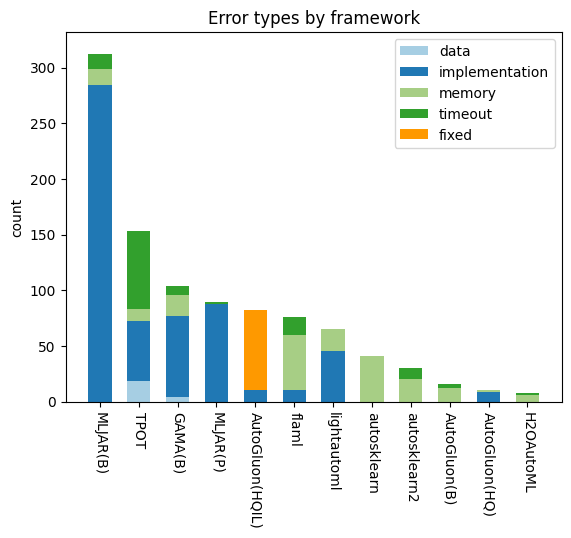

In [57]:
fig, ax = plt.subplots()

bottoms = np.zeros(len(frameworks))
for error_type, counts in errors_by_framework.items():
    ax.bar(frameworks, counts, label=error_type, bottom=bottoms, width=.6, color=color_by_error_type[error_type])
    bottoms += counts

ax.set_ylim([0, max(bottoms) + 20])
ax.set_ylabel("count")
ax.tick_params(axis="x", which="major", rotation=-90)
ax.legend(loc="upper right")
ax.set_title("Error types by framework")

with PdfPages(FIGURE_DIRECTORY / f"errors-by-type-1h8c_gp3.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

## Visualizing Errors by Dataset Size

In [58]:
errors_by_task = with_errors[~with_errors["error_type"].isin(["investigate","implementation"])].groupby("task").count()["info"]

In [59]:
metadata_path = DATA_DIRECTORY / "metadata.csv"
if metadata_path.is_file():
    metadata = pd.read_csv(metadata_path)
else:
    import openml
    regression = openml.study.get_suite(269)
    classification = openml.study.get_suite(271)
    metadata = openml.datasets.list_datasets(data_id=regression.data+classification.data, output_format="dataframe")
    metadata.to_csv(metadata_path, index=False)

In [60]:
all_results = metadata.set_index("name").join(errors_by_task)
all_results = all_results.fillna(0)
all_results = all_results.rename(columns=dict(info="count"))
errors = all_results[all_results["count"]>0].copy()
no_errors = all_results[all_results["count"]==0].copy()

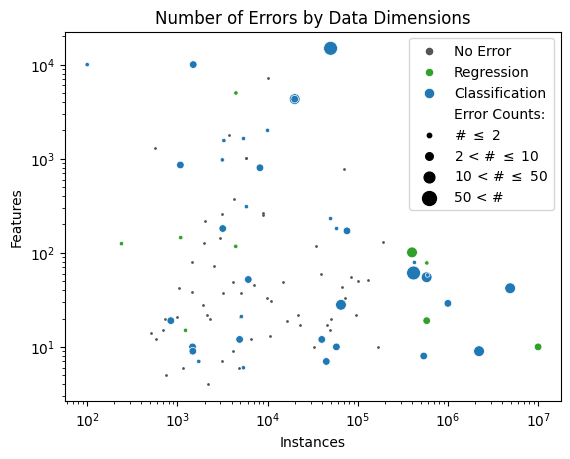

In [61]:
fig, ax = plt.subplots()

errors["marker_size"] = errors["count"].apply(lambda c: 10 if c<3 else (30 if c < 11 else (60 if c<51 else 100)))
classification = errors[errors["NumberOfClasses"] > 0]
regression = errors[errors["NumberOfClasses"] == 0]

ax.scatter(no_errors["NumberOfInstances"], no_errors["NumberOfFeatures"], color="#555555", s=1, label="No Error")
ax.scatter(regression["NumberOfInstances"], regression["NumberOfFeatures"], color="#32a02d", s=regression["marker_size"], label="Regression", edgecolors="white", linewidths=.5)
ax.scatter(classification["NumberOfInstances"], classification["NumberOfFeatures"], color="#2078b4", s=classification["marker_size"], label="Classification", edgecolors="white", linewidths=.5)

ax.scatter(0, 0, color="#ffffff", s=60, label="Error Counts:")
ax.scatter(0, 0, color="#000000", s=10, label="# $\leq$ 2")
ax.scatter(0, 0, color="#000000", s=30, label="2 < # $\leq$ 10")
ax.scatter(0, 0, color="#000000", s=60, label="10 < # $\leq$ 50")
ax.scatter(0, 0, color="#000000", s=100, label="50 < #")

ax.set_xscale("log")
ax.set_xlabel("Instances")
ax.set_yscale("log")
ax.set_ylabel("Features")
ax.set_title("Number of Errors by Data Dimensions")

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [20]
plt.show()


with PdfPages(FIGURE_DIRECTORY / f"errors-by-data-1h8c_gp3.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

# Comparison of 1h and 4h results
When we are comparing one hour to four hour results, we restrict our analysis to only those frameworks which have had a June 2023 evaluation for both time constraints:

In [62]:
from data_processing import is_old

In [128]:
errors_on_recent = with_errors[~with_errors.apply(lambda r: is_old(r["framework"], "4h8c_gp3", r["metric"]), axis=1)].copy()



Do errors happen more or less frequently in one hour or four hour results? Which errors?

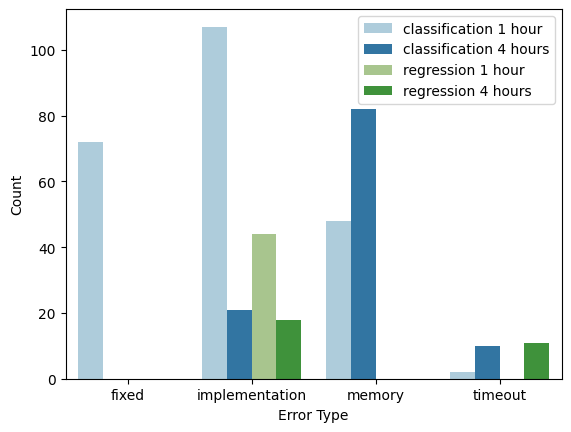

In [131]:
fig, ax = plt.subplots()

suite = {"neg_rmse": "regression", "auc": "classification", "neg_logloss": "classification"}

errors_on_recent["constraint-formatted"] = errors_on_recent["constraint"].apply(lambda s: "1 hour" if s == "1h8c_gp3" else "4 hours")
errors_on_recent["suite-and-constraint"] = errors_on_recent.apply(lambda r: suite[r["metric"]] + " " + r["constraint-formatted"] , axis=1)
errors_by_type_and_constraint = errors_on_recent.groupby(["suite-and-constraint", "error_type"], as_index=False).count()

errors_by_type_and_constraint = errors_by_type_and_constraint.rename(columns={"error_type": "Error Type", "constraint": "Time constraint", "info": "Count"})
errors_by_type_and_constraint = errors_by_type_and_constraint.drop(columns="metric")

hues = {
    "classification 1 hour": "#a6cee3",
    "classification 4 hours": "#2078b4",
    "regression 1 hour": "#A7CE85",
    "regression 4 hours":"#32a02d",
}

sns.barplot(
    errors_by_type_and_constraint,
    x="Error Type",
    y="Count",
    hue="suite-and-constraint",
    hue_order=hues.keys(),
    palette=hues,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

with PdfPages(FIGURE_DIRECTORY / f"errors-by-constraint.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

 Are there particular frameworks which error more frequently with longer time constraints?

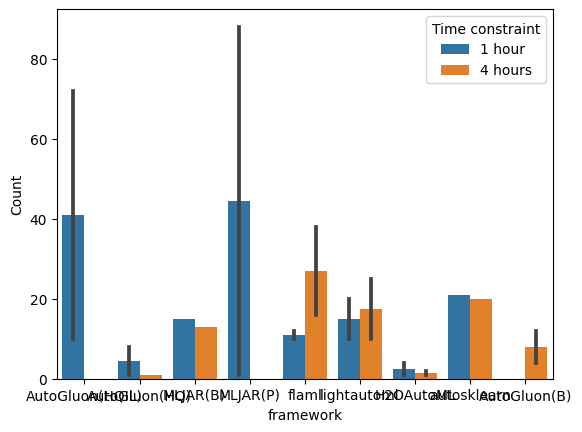

In [104]:
fig, ax = plt.subplots()

errors_by_type_and_constraint = errors_on_recent.groupby(["constraint", "error_type", "framework"], as_index=False).count()
errors_by_type_and_constraint["constraint"] = errors_by_type_and_constraint["constraint"].apply(lambda s: "1 hour" if s == "1h8c_gp3" else "4 hours")
errors_by_type_and_constraint = errors_by_type_and_constraint.rename(columns={"error_type": "Error Type", "constraint": "Time constraint", "info": "Count"})
sns.barplot(
    errors_by_type_and_constraint,
    x="framework",
    y="Count",
    hue="Time constraint",
)

with PdfPages(FIGURE_DIRECTORY / f"errors-by-constraint.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

In [105]:
errors_by_type_and_constraint

,Time constraint,Error Type,framework,task,fold,Count,metric
0,1 hour,fixed,AutoGluon(HQIL),72,72,72,72
1,1 hour,implementation,AutoGluon(HQ),8,8,8,8
2,1 hour,implementation,AutoGluon(HQIL),10,10,10,10
3,1 hour,implementation,MLJAR(B),15,15,15,15
4,1 hour,implementation,MLJAR(P),88,88,88,88
5,1 hour,implementation,flaml,10,10,10,10
6,1 hour,implementation,lightautoml,20,20,20,20
7,1 hour,memory,AutoGluon(HQ),1,1,1,1
8,1 hour,memory,H2OAutoML,4,4,4,4
9,1 hour,memory,autosklearn,21,21,21,21
